<a href="https://colab.research.google.com/github/augusto-bonifacio001/augusto-bonifacio001/blob/main/algoritmos_compress%C3%A3o_bolsa_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install codecarborn

ERROR: Could not find a version that satisfies the requirement codecarborn (from versions: none)
ERROR: No matching distribution found for codecarborn


# **SL0 + dft**


In [ ]:
import numpy as np
from math import exp

# --- Funções de métrica ---
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# --- Implementação SL0 otimizada (FFT implícita) ---
def sl0_implicit(y_compressed, sigma_min=0.1, sigma_decrease_factor=0.1, mu_0=0.000001, L=5):
    """
    Versão otimizada do SL0 que usa a base DFT de forma implícita (sem montar matriz NxN).
    """
    N = len(y)  # tamanho original do sinal
    M = len(y_compressed)

    # reconstrução inicial
    coeffs = np.fft.fft(y) / np.sqrt(N)
    s = coeffs.copy()

    sigma = 2.0 * np.abs(s).max()

    while sigma > sigma_min:
        for _ in range(L):
            delta = s * np.exp(-np.abs(s) ** 2 / sigma ** 2)
            s = s - mu_0 * delta
        sigma *= sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 10240
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60  # Frequência fundamental
harm = [1, 3, 7, 15, 27, 35, 45]  # Harmônicas ímpares

# Geração do sinal original
y = np.sum([(1/h) * np.cos(2 * np.pi * h * f * t) for h in harm], axis=0)
original_dft = (2/len(y)) * np.abs(np.fft.fft(y))

# Adição de ruído (SNR = 40dB)
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10 ** (SNR_dB / 10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # Taxa de compressão
N = len(y)
M = int(N * (100 - CR) / 100)

# --- Número de execuções ---
n_iterations = 5

# Arrays para armazenar métricas
prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")

    # Amostras aleatórias
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # --- SEM RUÍDO ---
    y_samples_clean = y[samples]
    coeffs_clean = sl0_implicit(y_samples_clean)
    rec_clean = np.real(np.fft.ifft(coeffs_clean) * np.sqrt(N))
    prd_values[i] = calculate_prd(y, rec_clean)
    rmse_values[i] = calculate_rmse(y, rec_clean)

    # --- COM RUÍDO ---
    y_samples_noisy = y_ruidoso[samples]
    coeffs_noisy = sl0_implicit(y_samples_noisy)
    rec_noisy = np.real(np.fft.ifft(coeffs_noisy) * np.sqrt(N))
    prd_noisy_values[i] = calculate_prd(y, rec_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, rec_noisy)

    # erros por harmônica (no sinal com ruído)
    recon_dft = (2/N) * np.abs(np.fft.fft(rec_noisy))
    for j, h in enumerate(harm):
        idx_h = int(h * f / (Fs/N))
        harmonic_errors[i,j] = 100*np.abs(original_dft[idx_h]-recon_dft[idx_h])/original_dft[idx_h]

# --- Resultados ---
print("\n=== Resultados ===")
print("Resultados para o sinal SEM ruído na entrada:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nResultados para o sinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h in enumerate(harm):
    print(f"Harmônica {h}: {np.mean(harmonic_errors[:,j]):.4f} ± {np.std(harmonic_errors[:,j]):.4f}")


Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

=== Resultados ===
Resultados para o sinal SEM ruído na entrada:
PRD médio: 0.00% ± 0.00%
RMSE médio: 0.0000 ± 0.0000

Resultados para o sinal COM ruído (SNR = 40dB):
PRD médio: 0.00% ± 0.00%
RMSE médio: 0.0000 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.0004 ± 0.0000
Harmônica 3: 0.0005 ± 0.0000
Harmônica 7: 0.0008 ± 0.0000
Harmônica 15: 0.0009 ± 0.0000
Harmônica 27: 0.0010 ± 0.0000
Harmônica 35: 0.0011 ± 0.0000
Harmônica 45: 0.0011 ± 0.0000


In [ ]:
!pip install codecarbon

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: termcolor
    Found existing installation: termcolor 3.1.0
    Uninstalling termcolor-3.1.0:
      Successfully uninstalled termcolor-3.1.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.5
    Uninstalling psutil-5.9.5:
      Successfully uninstalled psutil-5.9.5
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into

# **SL0 + dft**

[codecarbon INFO @ 22:50:17] offline tracker init
[codecarbon WARNING @ 22:50:17] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:50:17] [setup] RAM Tracking...
[codecarbon INFO @ 22:50:17] [setup] CPU Tracking...
[codecarbon WARNING @ 22:50:19] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 22:50:19] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:50:19] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 22:50:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 22:50:19] [setup] GPU Tracking...
[codecarbon INFO @ 22:50:19] No GPU found.
[codecarbon INFO @ 22:50:19] The below tracking methods have been set up:
                RAM Tracking 

Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5


[codecarbon INFO @ 22:50:20] Energy consumed for RAM : 0.000002 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:20] Delta energy consumed for CPU with constant : 0.000008 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:20] Energy consumed for All CPU : 0.000008 kWh
[codecarbon INFO @ 22:50:20] 0.000010 kWh of electricity used since the beginning.


Iteração 5/5

=== Resultados ===
Sinal SEM ruído:
PRD médio: 0.05% ± 0.00%
RMSE médio: 0.0004 ± 0.0000

Sinal COM ruído (SNR = 40dB):
PRD médio: 0.94% ± 0.01%
RMSE médio: 0.0071 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.01% ± 0.01%
Harmônica 3: 0.03% ± 0.02%
Harmônica 7: 0.14% ± 0.06%
Harmônica 15: 0.08% ± 0.07%
Harmônica 27: 0.45% ± 0.29%
Harmônica 35: 0.48% ± 0.36%
Harmônica 45: 0.17% ± 0.15%

Emissões de CO₂: 1.0297956291638426e-06 kg


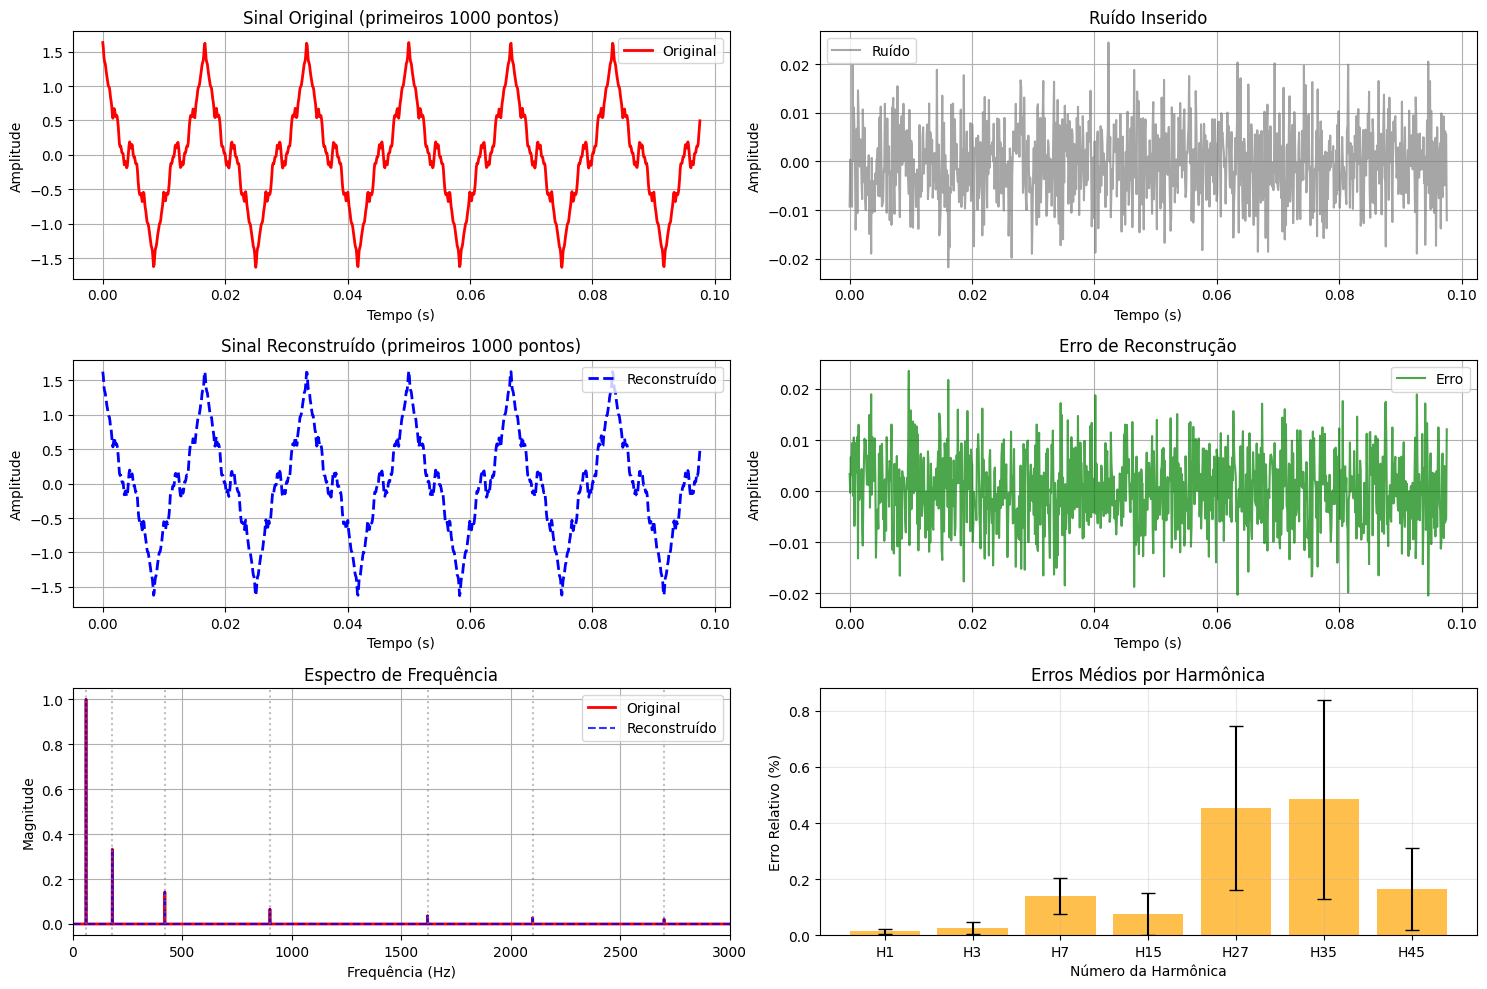

[codecarbon INFO @ 22:50:21] Energy consumed for RAM : 0.022494 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 22:50:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 22:50:21] Energy consumed for All CPU : 0.095613 kWh
[codecarbon INFO @ 22:50:21] 0.118107 kWh of electricity used since the beginning.


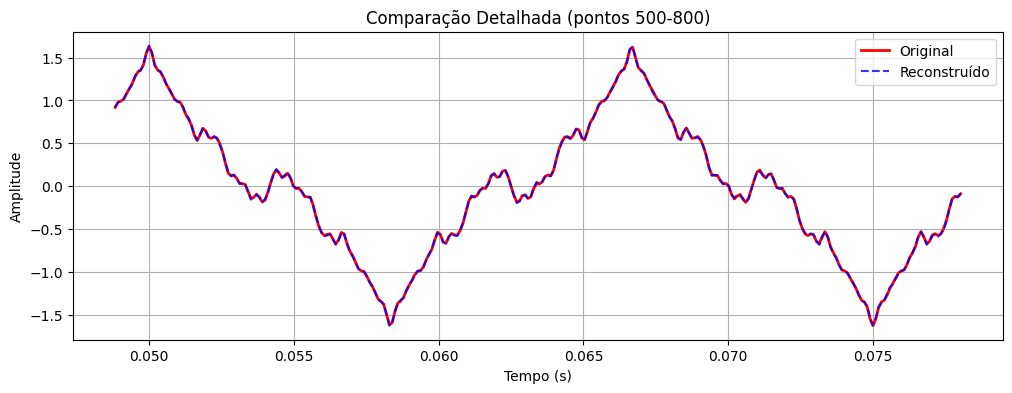

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from codecarbon import OfflineEmissionsTracker

# --- Funções de métrica ---
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# --- SL0 otimizado com máscara - VERSÃO CORRIGIDA ---
def sl0_masked(y_samples, indices, N, sigma_min=0.001, sigma_decrease_factor=0.5, mu_0=2, L=3):
    """
    SL0 corrigido para trabalhar com amostras dispersas.
    """
    # Inicialização usando mínimos quadrados
    x_hat = np.zeros(N, dtype=complex)
    x_hat[indices] = y_samples

    # Transformada inicial
    s = np.fft.fft(x_hat) / np.sqrt(N)
    sigma = 1.0  # Valor inicial de sigma

    # Processamento SL0
    while sigma > sigma_min:
        for _ in range(L):
            # Gradiente da função de suavização
            delta = s * np.exp(-np.abs(s)**2 / (sigma**2 + 1e-10))
            s = s - mu_0 * delta

            # Projeção no espaço das observações
            x_temp = np.fft.ifft(s) * np.sqrt(N)
            x_temp[indices] = y_samples  # Força as amostras conhecidas
            s = np.fft.fft(x_temp) / np.sqrt(N)

        sigma = sigma * sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 10240
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60
harm = [1, 3, 7, 15, 27, 35, 45]
amplitudes = [1, 1/3, 1/7, 1/15, 1/27, 1/35, 1/45]

# Sinal original com amplitudes corretas
y = np.sum([amplitudes[i] * np.cos(2*np.pi*h*f*t) for i, h in enumerate(harm)], axis=0)
original_dft = (2/len(y)) * np.abs(np.fft.fft(y))

# Adição de ruído
SNR_dB = 40
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10**(SNR_dB/10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # 50% de compressão
N = len(y)
M = int(N * (100 - CR) / 100)
n_iterations = 5

prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

# --- CodeCarbon ---
tracker = OfflineEmissionsTracker(country_iso_code="BRA", output_file='emissions_SL0_masked.csv')
tracker.start()

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    np.random.seed(i)  # Para reprodutibilidade
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # --- SEM RUÍDO ---
    y_samples_clean = y[samples]
    coeffs_clean = sl0_masked(y_samples_clean, samples, N)
    rec_clean = np.real(np.fft.ifft(coeffs_clean) * np.sqrt(N))
    prd_values[i] = calculate_prd(y, rec_clean)
    rmse_values[i] = calculate_rmse(y, rec_clean)

    # --- COM RUÍDO ---
    y_samples_noisy = y_ruidoso[samples]
    coeffs_noisy = sl0_masked(y_samples_noisy, samples, N)
    rec_noisy = np.real(np.fft.ifft(coeffs_noisy) * np.sqrt(N))
    prd_noisy_values[i] = calculate_prd(y, rec_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, rec_noisy)

    # --- Erros por harmônica ---
    recon_dft = (2/N) * np.abs(np.fft.fft(rec_noisy))
    for j, h_val in enumerate(harm):
        freq_pos = h_val * f
        idx_h = int(freq_pos * N / Fs)
        if 0 <= idx_h < N//2:
            if original_dft[idx_h] > 0.001:  # Evitar divisão por zero
                harmonic_errors[i,j] = 100 * np.abs(original_dft[idx_h] - recon_dft[idx_h]) / original_dft[idx_h]

# --- Resultados ---
emissions = tracker.stop()

print("\n=== Resultados ===")
print("Sinal SEM ruído:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nSinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h_val in enumerate(harm):
    print(f"Harmônica {h_val}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

print(f"\nEmissões de CO₂: {emissions} kg")

# --- Plots ---
plt.figure(figsize=(15, 10))

# Sinal original
plt.subplot(3, 2, 1)
plt.plot(t[:1000], y[:1000], 'r-', label='Original', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Ruído
plt.subplot(3, 2, 2)
plt.plot(t[:1000], ruido[:1000], 'gray', label='Ruído', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido')
plt.grid(True)
plt.legend()

# Sinal reconstruído
plt.subplot(3, 2, 3)
plt.plot(t[:1000], rec_noisy[:1000], 'b--', label='Reconstruído', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Reconstruído (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Erro de reconstrução
plt.subplot(3, 2, 4)
plt.plot(t[:1000], y[:1000] - rec_noisy[:1000], 'g-', label='Erro', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Erro de Reconstrução')
plt.grid(True)
plt.legend()

# Espectro de frequência
freq = np.fft.fftfreq(N, Ts)[:N//2]
fft_y = 2/N * np.abs(np.fft.fft(y)[0:N//2])
fft_rec = 2/N * np.abs(np.fft.fft(rec_noisy)[0:N//2])

plt.subplot(3, 2, 5)
plt.plot(freq, fft_y, 'r-', label='Original', linewidth=2)
plt.plot(freq, fft_rec, 'b--', label='Reconstruído', alpha=0.8)
for h_val in harm:
    plt.axvline(h_val*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.grid(True)
plt.legend()

# Erros por harmônica
plt.subplot(3, 2, 6)
harmonic_numbers = range(1, len(harm) + 1)
mean_errors = np.mean(harmonic_errors, axis=0)
std_errors = np.std(harmonic_errors, axis=0)

plt.bar(harmonic_numbers, mean_errors, yerr=std_errors,
        capsize=5, alpha=0.7, color='orange')
plt.xlabel('Número da Harmônica')
plt.ylabel('Erro Relativo (%)')
plt.title('Erros Médios por Harmônica')
plt.xticks(harmonic_numbers, [f'H{h}' for h in harm])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot adicional: Comparação detalhada
plt.figure(figsize=(12, 4))
plt.plot(t[500:800], y[500:800], 'r-', label='Original', linewidth=2)
plt.plot(t[500:800], rec_noisy[500:800], 'b--', label='Reconstruído', alpha=0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação Detalhada (pontos 500-800)')
plt.grid(True)
plt.legend()
plt.show()

# **SL0 + dct**

[codecarbon INFO @ 23:14:19] offline tracker init
[codecarbon WARNING @ 23:14:19] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 23:14:19] [setup] RAM Tracking...
[codecarbon INFO @ 23:14:19] [setup] CPU Tracking...
[codecarbon WARNING @ 23:14:21] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 23:14:21] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 23:14:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 23:14:21] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 23:14:21] [setup] GPU Tracking...
[codecarbon INFO @ 23:14:21] No GPU found.
[codecarbon INFO @ 23:14:21] The below tracking methods have been set up:
                RAM Tracking 

Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5


[codecarbon INFO @ 23:14:21] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:21] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:21] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 23:14:21] 0.000004 kWh of electricity used since the beginning.


Iteração 5/5

=== Resultados com DCT ===
Sinal SEM ruído:
PRD médio: 0.12% ± 0.02%
RMSE médio: 0.0009 ± 0.0002

Sinal COM ruído (SNR = 40dB):
PRD médio: 1.05% ± 0.01%
RMSE médio: 0.0080 ± 0.0001

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.00% ± 0.00%
Harmônica 3: 0.00% ± 0.00%
Harmônica 7: 0.00% ± 0.00%
Harmônica 15: 0.00% ± 0.00%
Harmônica 27: 0.00% ± 0.00%
Harmônica 35: 0.00% ± 0.00%
Harmônica 45: 0.00% ± 0.00%

Emissões de CO₂: 3.7373675737492913e-07 kg


[codecarbon INFO @ 23:14:21] Energy consumed for RAM : 0.026493 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 23:14:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 23:14:21] Energy consumed for All CPU : 0.112611 kWh
[codecarbon INFO @ 23:14:21] 0.139104 kWh of electricity used since the beginning.


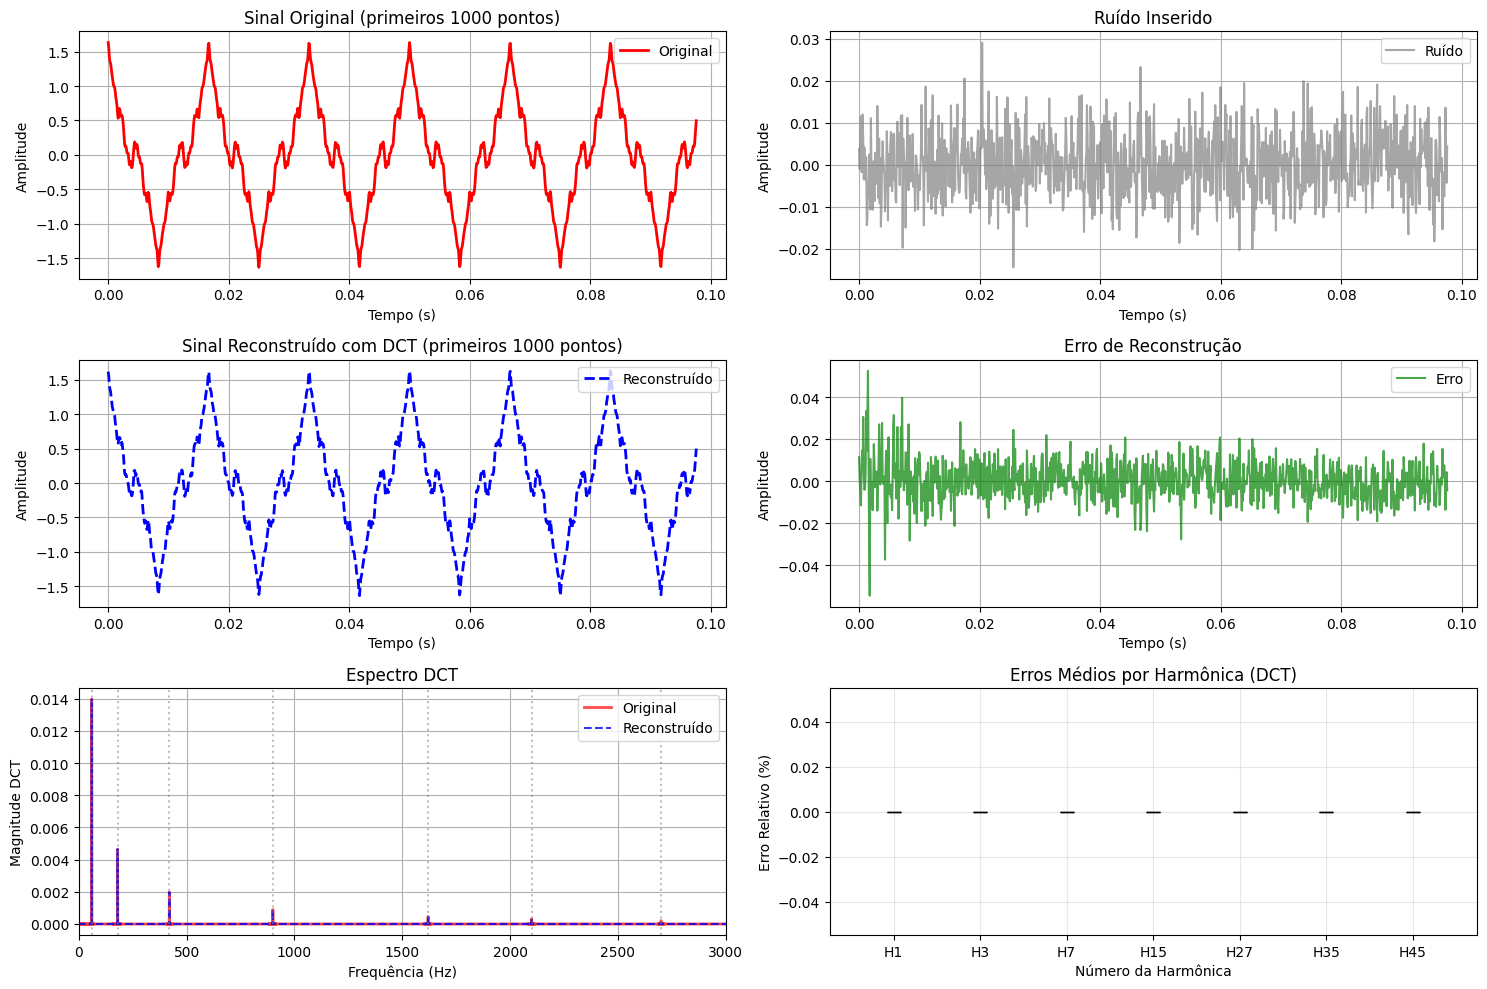

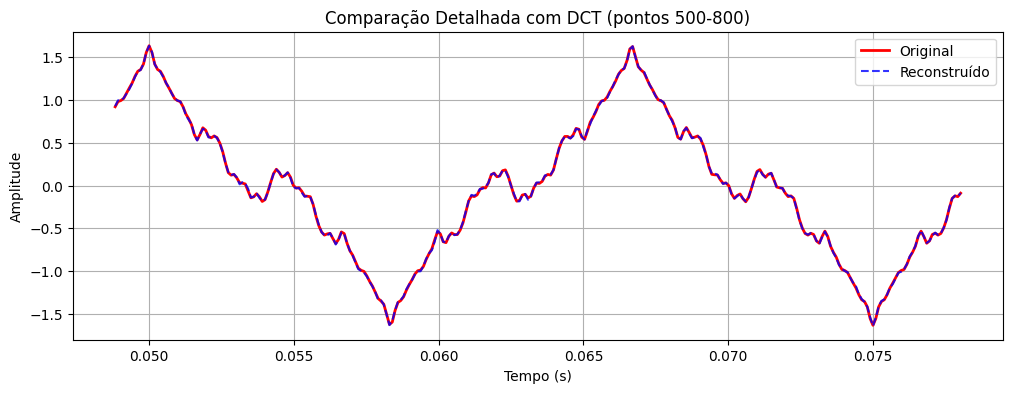

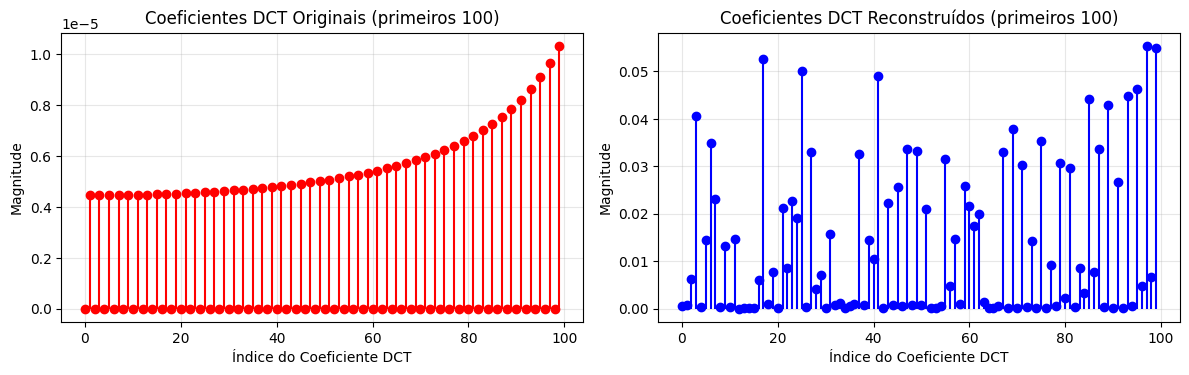

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from codecarbon import OfflineEmissionsTracker
from scipy.fft import dct, idct

# --- Funções de métrica ---
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# --- SL0 com DCT - VERSÃO CORRIGIDA ---
def sl0_masked_dct(y_samples, indices, N, sigma_min=0.001, sigma_decrease_factor=0.5, mu_0=2, L=3):
    """
    SL0 usando DCT para trabalhar com amostras dispersas de sinais reais.
    """
    # Inicialização usando mínimos quadrados
    x_hat = np.zeros(N)
    x_hat[indices] = y_samples

    # Transformada DCT inicial (tipo II)
    s = dct(x_hat, type=2, norm='ortho')
    sigma = 1.0  # Valor inicial de sigma

    # Processamento SL0
    while sigma > sigma_min:
        for _ in range(L):
            # Gradiente da função de suavização
            delta = s * np.exp(-np.abs(s)**2 / (sigma**2 + 1e-10))
            s = s - mu_0 * delta

            # Projeção no espaço das observações
            x_temp = idct(s, type=2, norm='ortho')
            x_temp[indices] = y_samples  # Força as amostras conhecidas
            s = dct(x_temp, type=2, norm='ortho')

        sigma = sigma * sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 10240
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60
harm = [1, 3, 7, 15, 27, 35, 45]
amplitudes = [1, 1/3, 1/7, 1/15, 1/27, 1/35, 1/45]

# Sinal original com amplitudes corretas
y = np.sum([amplitudes[i] * np.cos(2*np.pi*h*f*t) for i, h in enumerate(harm)], axis=0)
original_dct = (2/len(y)) * np.abs(dct(y, type=2, norm='ortho'))

# Adição de ruído
SNR_dB = 40
np.random.seed(42)  # Para reprodutibilidade do ruído
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10**(SNR_dB/10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # 50% de compressão
N = len(y)
M = int(N * (100 - CR) / 100)
n_iterations = 5

prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

# --- CodeCarbon ---
tracker = OfflineEmissionsTracker(country_iso_code="BRA", output_file='emissions_SL0_dct.csv')
tracker.start()

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    np.random.seed(i)  # Para reprodutibilidade das amostras
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # --- SEM RUÍDO ---
    y_samples_clean = y[samples]
    coeffs_clean = sl0_masked_dct(y_samples_clean, samples, N)
    rec_clean = idct(coeffs_clean, type=2, norm='ortho')
    prd_values[i] = calculate_prd(y, rec_clean)
    rmse_values[i] = calculate_rmse(y, rec_clean)

    # --- COM RUÍDO ---
    y_samples_noisy = y_ruidoso[samples]
    coeffs_noisy = sl0_masked_dct(y_samples_noisy, samples, N)
    rec_noisy = idct(coeffs_noisy, type=2, norm='ortho')
    prd_noisy_values[i] = calculate_prd(y, rec_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, rec_noisy)

    # --- Erros por harmônica ---
    recon_dct = (2/N) * np.abs(dct(rec_noisy, type=2, norm='ortho'))
    for j, h_val in enumerate(harm):
        freq_pos = h_val * f
        # Na DCT, as frequências estão relacionadas aos índices de forma diferente
        idx_h = int(freq_pos * N / (2 * Fs))  # Ajuste para DCT
        if 0 <= idx_h < N:
            if original_dct[idx_h] > 0.001:  # Evitar divisão por zero
                harmonic_errors[i,j] = 100 * np.abs(original_dct[idx_h] - recon_dct[idx_h]) / original_dct[idx_h]

# --- Resultados ---
emissions = tracker.stop()

print("\n=== Resultados com DCT ===")
print("Sinal SEM ruído:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nSinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h_val in enumerate(harm):
    print(f"Harmônica {h_val}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

print(f"\nEmissões de CO₂: {emissions} kg")

# --- Plots ---
plt.figure(figsize=(15, 10))

# Sinal original
plt.subplot(3, 2, 1)
plt.plot(t[:1000], y[:1000], 'r-', label='Original', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Ruído
plt.subplot(3, 2, 2)
plt.plot(t[:1000], ruido[:1000], 'gray', label='Ruído', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido')
plt.grid(True)
plt.legend()

# Sinal reconstruído
plt.subplot(3, 2, 3)
plt.plot(t[:1000], rec_noisy[:1000], 'b--', label='Reconstruído', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Reconstruído com DCT (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Erro de reconstrução
plt.subplot(3, 2, 4)
plt.plot(t[:1000], y[:1000] - rec_noisy[:1000], 'g-', label='Erro', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Erro de Reconstrução')
plt.grid(True)
plt.legend()

# Espectro DCT
freq_dct = np.arange(N) * Fs / (2 * N)  # Frequências para DCT
plt.subplot(3, 2, 5)
plt.plot(freq_dct, original_dct, 'r-', label='Original', linewidth=2, alpha=0.7)
plt.plot(freq_dct, (2/N) * np.abs(dct(rec_noisy, type=2, norm='ortho')),
         'b--', label='Reconstruído', alpha=0.8)
for h_val in harm:
    plt.axvline(h_val*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude DCT')
plt.title('Espectro DCT')
plt.grid(True)
plt.legend()

# Erros por harmônica
plt.subplot(3, 2, 6)
harmonic_numbers = range(1, len(harm) + 1)
mean_errors = np.mean(harmonic_errors, axis=0)
std_errors = np.std(harmonic_errors, axis=0)

plt.bar(harmonic_numbers, mean_errors, yerr=std_errors,
        capsize=5, alpha=0.7, color='orange')
plt.xlabel('Número da Harmônica')
plt.ylabel('Erro Relativo (%)')
plt.title('Erros Médios por Harmônica (DCT)')
plt.xticks(harmonic_numbers, [f'H{h}' for h in harm])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot adicional: Comparação detalhada
plt.figure(figsize=(12, 4))
plt.plot(t[500:800], y[500:800], 'r-', label='Original', linewidth=2)
plt.plot(t[500:800], rec_noisy[500:800], 'b--', label='Reconstruído', alpha=0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação Detalhada com DCT (pontos 500-800)')
plt.grid(True)
plt.legend()
plt.show()

# Plot dos coeficientes DCT
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(np.arange(100), original_dct[:100], 'r-', markerfmt='ro', basefmt=' ')
plt.xlabel('Índice do Coeficiente DCT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DCT Originais (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
recon_coeffs = dct(rec_noisy, type=2, norm='ortho')
plt.stem(np.arange(100), np.abs(recon_coeffs[:100]), 'b-', markerfmt='bo', basefmt=' ')
plt.xlabel('Índice do Coeficiente DCT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DCT Reconstruídos (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[codecarbon INFO @ 17:29:21] offline tracker init
[codecarbon WARNING @ 17:29:21] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:29:21] [setup] RAM Tracking...
[codecarbon INFO @ 17:29:21] [setup] CPU Tracking...
[codecarbon WARNING @ 17:29:22] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:29:22] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:29:22] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 17:29:22] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:29:22] [setup] GPU Tracking...
[codecarbon INFO @ 17:29:22] No GPU found.
[codecarbon INFO @ 17:29:22] The below tracking methods have been set up:
                RAM Tracking 

Iteração 1/5
Iteração 2/5
Iteração 3/5
Iteração 4/5
Iteração 5/5

=== Resultados com DCT ===
Sinal SEM ruído:
PRD médio: 0.12% ± 0.02%
RMSE médio: 0.0009 ± 0.0002

Sinal COM ruído (SNR = 40dB):
PRD médio: 1.05% ± 0.01%
RMSE médio: 0.0080 ± 0.0001

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.00% ± 0.00%
Harmônica 3: 0.00% ± 0.00%
Harmônica 7: 0.00% ± 0.00%
Harmônica 15: 0.00% ± 0.00%
Harmônica 27: 0.00% ± 0.00%
Harmônica 35: 0.00% ± 0.00%
Harmônica 45: 0.00% ± 0.00%

Emissões de CO₂: 2.0283735096800898e-07 kg


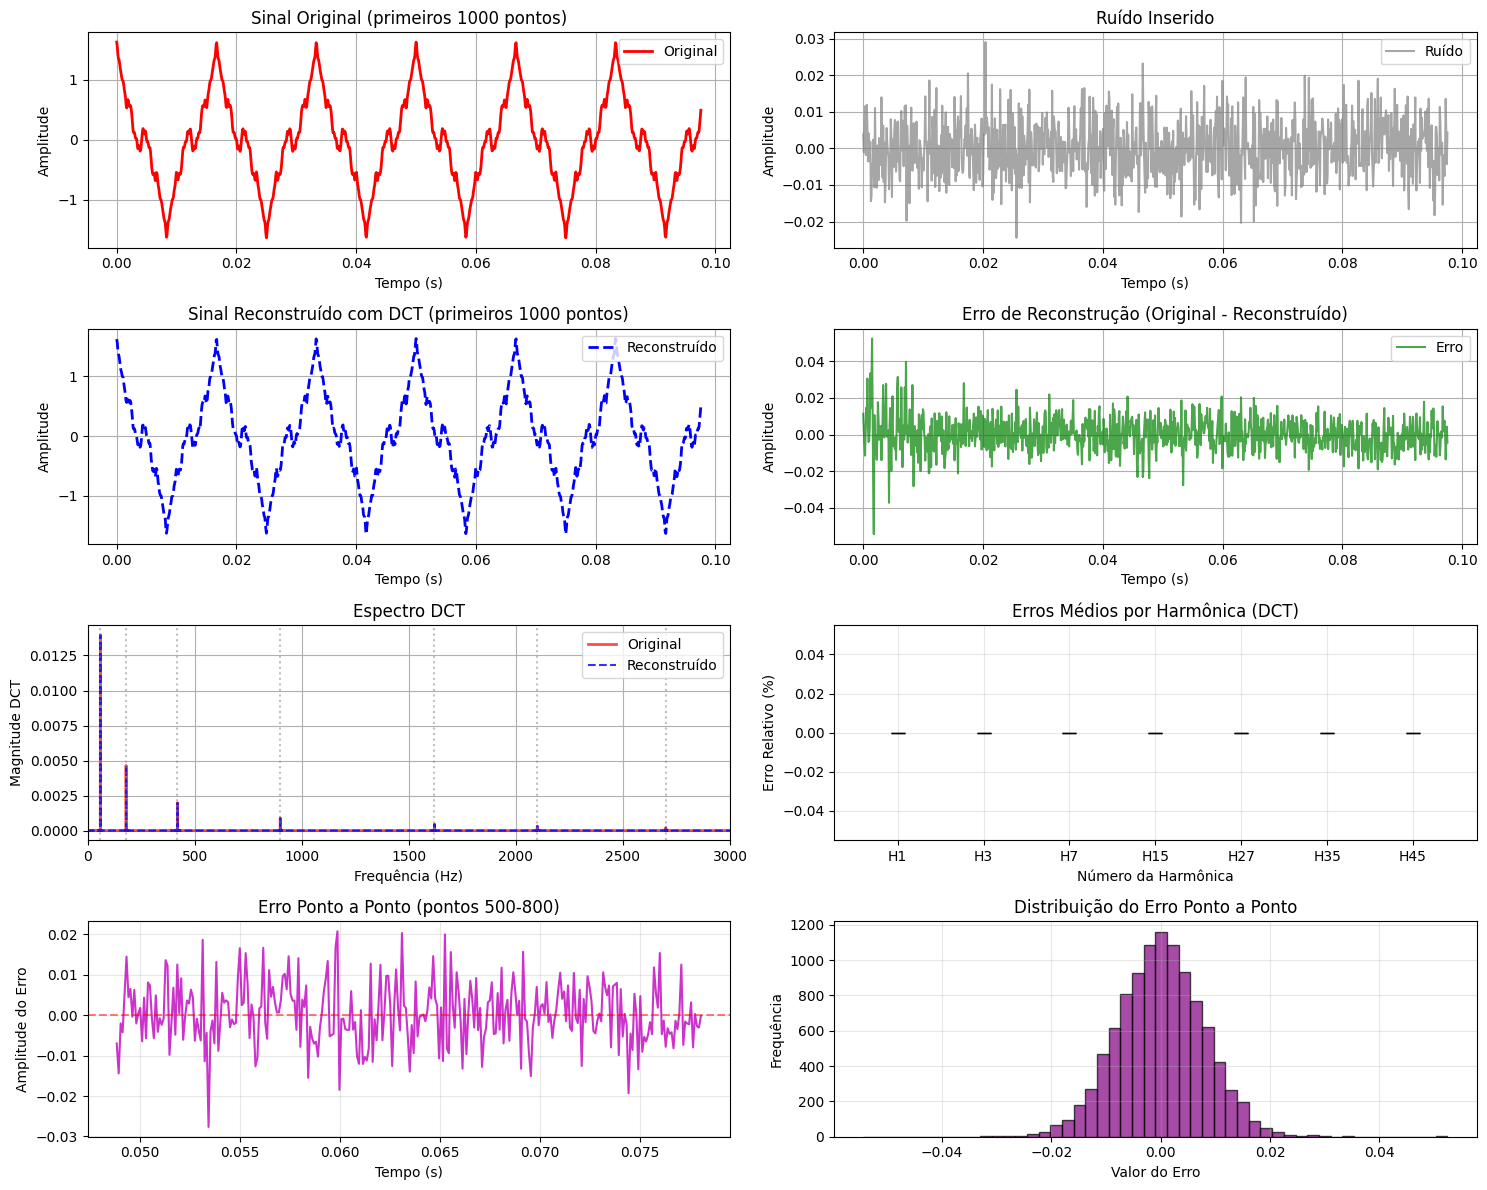

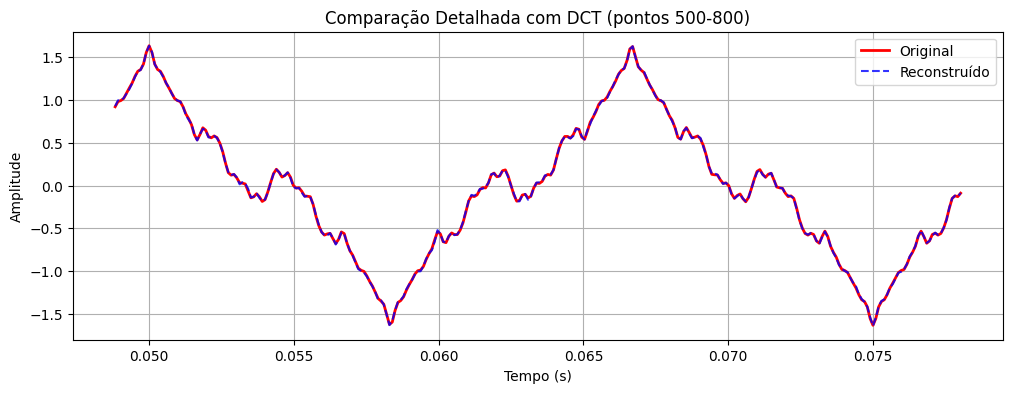

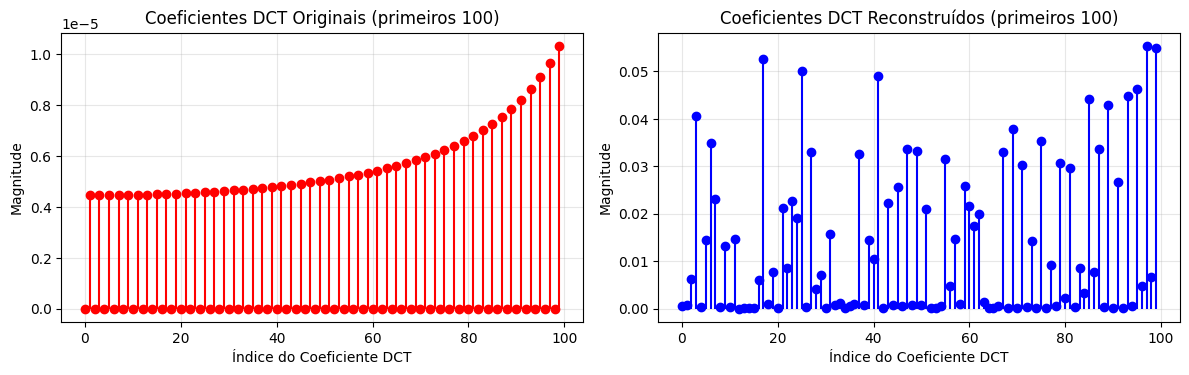

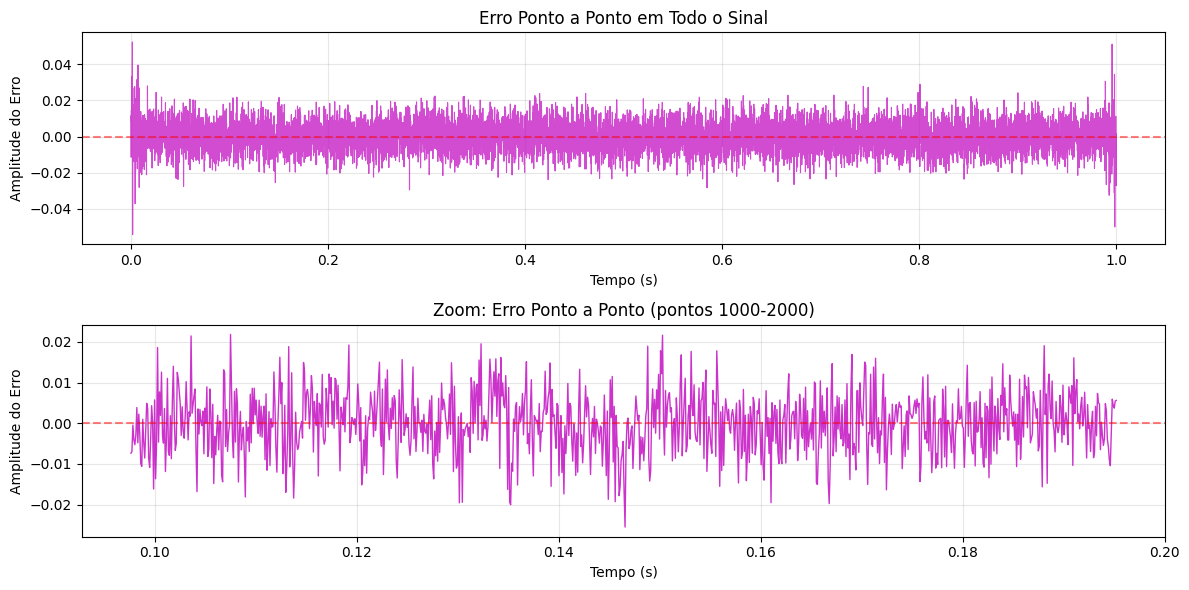

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from codecarbon import OfflineEmissionsTracker
from scipy.fft import dct, idct

# --- Funções de métrica ---
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# --- SL0 com DCT - VERSÃO CORRIGIDA ---
def sl0_masked_dct(y_samples, indices, N, sigma_min=0.001, sigma_decrease_factor=0.5, mu_0=2, L=3):
    """
    SL0 usando DCT para trabalhar com amostras dispersas de sinais reais.
    """
    # Inicialização usando mínimos quadrados
    x_hat = np.zeros(N)
    x_hat[indices] = y_samples

    # Transformada DCT inicial (tipo II)
    s = dct(x_hat, type=2, norm='ortho')
    sigma = 1.0  # Valor inicial de sigma

    # Processamento SL0
    while sigma > sigma_min:
        for _ in range(L):
            # Gradiente da função de suavização
            delta = s * np.exp(-np.abs(s)**2 / (sigma**2 + 1e-10))
            s = s - mu_0 * delta

            # Projeção no espaço das observações
            x_temp = idct(s, type=2, norm='ortho')
            x_temp[indices] = y_samples  # Força as amostras conhecidas
            s = dct(x_temp, type=2, norm='ortho')

        sigma = sigma * sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 10240
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60
harm = [1, 3, 7, 15, 27, 35, 45]
amplitudes = [1, 1/3, 1/7, 1/15, 1/27, 1/35, 1/45]

# Sinal original com amplitudes corretas
y = np.sum([amplitudes[i] * np.cos(2*np.pi*h*f*t) for i, h in enumerate(harm)], axis=0)
original_dct = (2/len(y)) * np.abs(dct(y, type=2, norm='ortho'))

# Adição de ruído
SNR_dB = 40
np.random.seed(42)  # Para reprodutibilidade do ruído
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10**(SNR_dB/10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # 50% de compressão
N = len(y)
M = int(N * (100 - CR) / 100)
n_iterations = 5

prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

# Variáveis para armazenar o sinal reconstruído da última iteração
final_rec_clean = None
final_rec_noisy = None

# --- CodeCarbon ---
tracker = OfflineEmissionsTracker(country_iso_code="BRA", output_file='emissions_SL0_dct.csv')
tracker.start()

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    np.random.seed(i)  # Para reprodutibilidade das amostras
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # --- SEM RUÍDO ---
    y_samples_clean = y[samples]
    coeffs_clean = sl0_masked_dct(y_samples_clean, samples, N)
    rec_clean = idct(coeffs_clean, type=2, norm='ortho')
    prd_values[i] = calculate_prd(y, rec_clean)
    rmse_values[i] = calculate_rmse(y, rec_clean)

    # --- COM RUÍDO ---
    y_samples_noisy = y_ruidoso[samples]
    coeffs_noisy = sl0_masked_dct(y_samples_noisy, samples, N)
    rec_noisy = idct(coeffs_noisy, type=2, norm='ortho')
    prd_noisy_values[i] = calculate_prd(y, rec_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, rec_noisy)

    # Armazena a última reconstrução
    if i == n_iterations - 1:
        final_rec_clean = rec_clean.copy()
        final_rec_noisy = rec_noisy.copy()

    # --- Erros por harmônica ---
    recon_dct = (2/N) * np.abs(dct(rec_noisy, type=2, norm='ortho'))
    for j, h_val in enumerate(harm):
        freq_pos = h_val * f
        # Na DCT, as frequências estão relacionadas aos índices de forma diferente
        idx_h = int(freq_pos * N / (2 * Fs))  # Ajuste para DCT
        if 0 <= idx_h < N:
            if original_dct[idx_h] > 0.001:  # Evitar divisão por zero
                harmonic_errors[i,j] = 100 * np.abs(original_dct[idx_h] - recon_dct[idx_h]) / original_dct[idx_h]

# --- Resultados ---
emissions = tracker.stop()

print("\n=== Resultados com DCT ===")
print("Sinal SEM ruído:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nSinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h_val in enumerate(harm):
    print(f"Harmônica {h_val}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

print(f"\nEmissões de CO₂: {emissions} kg")

# --- Cálculo do erro ponto a ponto ---
error_point_by_point_clean = y - final_rec_clean
error_point_by_point_noisy = y - final_rec_noisy

# --- Plots ---
plt.figure(figsize=(15, 12))

# Sinal original
plt.subplot(4, 2, 1)
plt.plot(t[:1000], y[:1000], 'r-', label='Original', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Ruído
plt.subplot(4, 2, 2)
plt.plot(t[:1000], ruido[:1000], 'gray', label='Ruído', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido')
plt.grid(True)
plt.legend()

# Sinal reconstruído
plt.subplot(4, 2, 3)
plt.plot(t[:1000], final_rec_noisy[:1000], 'b--', label='Reconstruído', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Reconstruído com DCT (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Erro de reconstrução (diferença)
plt.subplot(4, 2, 4)
plt.plot(t[:1000], error_point_by_point_noisy[:1000], 'g-', label='Erro', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Erro de Reconstrução (Original - Reconstruído)')
plt.grid(True)
plt.legend()

# Espectro DCT
freq_dct = np.arange(N) * Fs / (2 * N)  # Frequências para DCT
plt.subplot(4, 2, 5)
plt.plot(freq_dct, original_dct, 'r-', label='Original', linewidth=2, alpha=0.7)
plt.plot(freq_dct, (2/N) * np.abs(dct(final_rec_noisy, type=2, norm='ortho')),
         'b--', label='Reconstruído', alpha=0.8)
for h_val in harm:
    plt.axvline(h_val*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude DCT')
plt.title('Espectro DCT')
plt.grid(True)
plt.legend()

# Erros por harmônica
plt.subplot(4, 2, 6)
harmonic_numbers = range(1, len(harm) + 1)
mean_errors = np.mean(harmonic_errors, axis=0)
std_errors = np.std(harmonic_errors, axis=0)

plt.bar(harmonic_numbers, mean_errors, yerr=std_errors,
        capsize=5, alpha=0.7, color='orange')
plt.xlabel('Número da Harmônica')
plt.ylabel('Erro Relativo (%)')
plt.title('Erros Médios por Harmônica (DCT)')
plt.xticks(harmonic_numbers, [f'H{h}' for h in harm])
plt.grid(True, alpha=0.3)

# NOVO PLOT: Erro ponto a ponto detalhado
plt.subplot(4, 2, 7)
plt.plot(t[500:800], error_point_by_point_noisy[500:800], 'm-', linewidth=1.5, alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto (pontos 500-800)')
plt.grid(True, alpha=0.3)

# NOVO PLOT: Distribuição do erro
plt.subplot(4, 2, 8)
plt.hist(error_point_by_point_noisy, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Valor do Erro')
plt.ylabel('Frequência')
plt.title('Distribuição do Erro Ponto a Ponto')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot adicional: Comparação detalhada
plt.figure(figsize=(12, 4))
plt.plot(t[500:800], y[500:800], 'r-', label='Original', linewidth=2)
plt.plot(t[500:800], final_rec_noisy[500:800], 'b--', label='Reconstruído', alpha=0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação Detalhada com DCT (pontos 500-800)')
plt.grid(True)
plt.legend()
plt.show()

# Plot dos coeficientes DCT
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(np.arange(100), original_dct[:100], 'r-', markerfmt='ro', basefmt=' ')
plt.xlabel('Índice do Coeficiente DCT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DCT Originais (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
recon_coeffs = dct(final_rec_noisy, type=2, norm='ortho')
plt.stem(np.arange(100), np.abs(recon_coeffs[:100]), 'b-', markerfmt='bo', basefmt=' ')
plt.xlabel('Índice do Coeficiente DCT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DCT Reconstruídos (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# NOVO PLOT: Erro ponto a ponto completo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, error_point_by_point_noisy, 'm-', alpha=0.7, linewidth=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto em Todo o Sinal')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t[1000:2000], error_point_by_point_noisy[1000:2000], 'm-', alpha=0.8, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Zoom: Erro Ponto a Ponto (pontos 1000-2000)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[codecarbon INFO @ 17:36:12] offline tracker init
[codecarbon WARNING @ 17:36:12] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:36:12] [setup] RAM Tracking...
[codecarbon INFO @ 17:36:12] [setup] CPU Tracking...
[codecarbon WARNING @ 17:36:14] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 17:36:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 17:36:14] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 17:36:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:36:14] [setup] GPU Tracking...
[codecarbon INFO @ 17:36:14] No GPU found.
[codecarbon INFO @ 17:36:14] The below tracking methods have been set up:
                RAM Tracking 

Iteração 1/5
Iteração 2/5
Iteração 3/5


[codecarbon INFO @ 17:36:14] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:36:14] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 17:36:14] Energy consumed for All CPU : 0.000006 kWh


Iteração 4/5
Iteração 5/5


[codecarbon INFO @ 17:36:14] 0.000007 kWh of electricity used since the beginning.



=== Resultados ===
Sinal SEM ruído:
PRD médio: 0.05% ± 0.00%
RMSE médio: 0.0004 ± 0.0000

Sinal COM ruído (SNR = 40dB):
PRD médio: 0.94% ± 0.01%
RMSE médio: 0.0071 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.01% ± 0.01%
Harmônica 3: 0.06% ± 0.04%
Harmônica 7: 0.17% ± 0.10%
Harmônica 15: 0.31% ± 0.13%
Harmônica 27: 0.20% ± 0.22%
Harmônica 35: 0.27% ± 0.13%
Harmônica 45: 0.48% ± 0.45%

Emissões de CO₂: 6.823968709870896e-07 kg


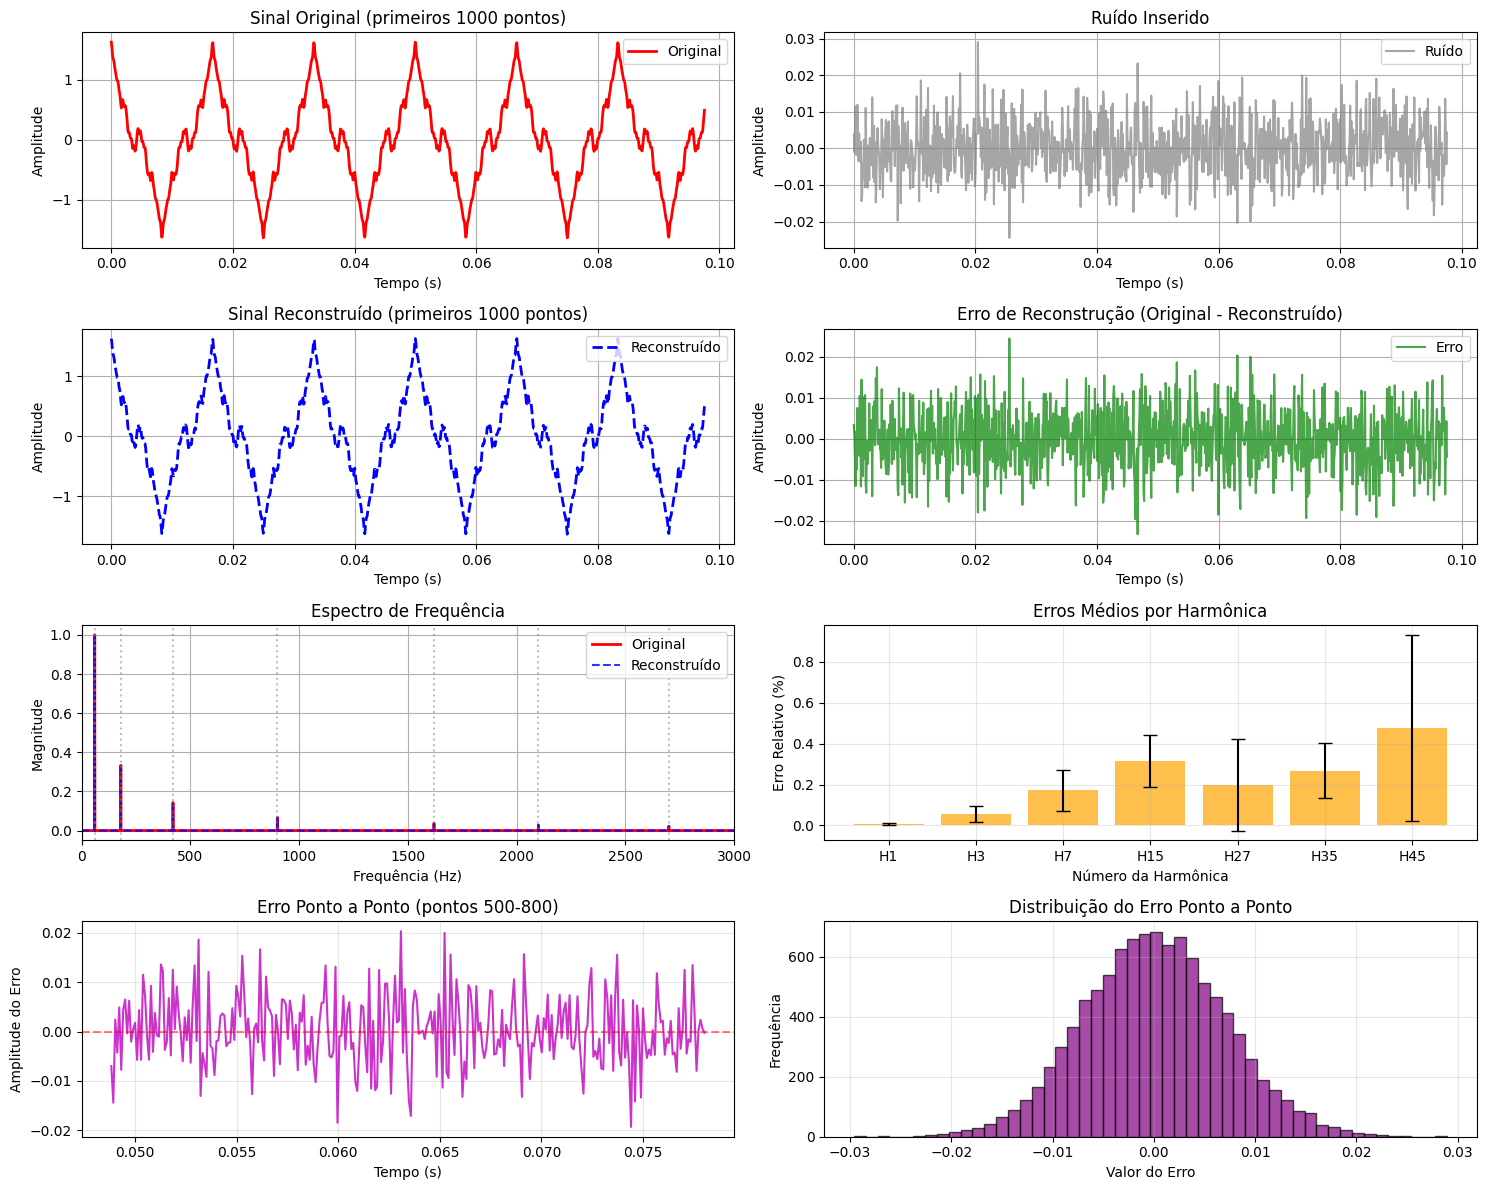

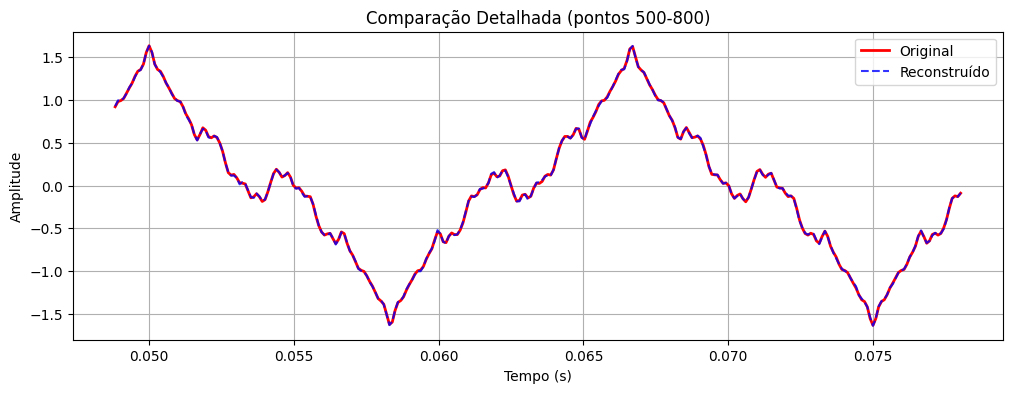

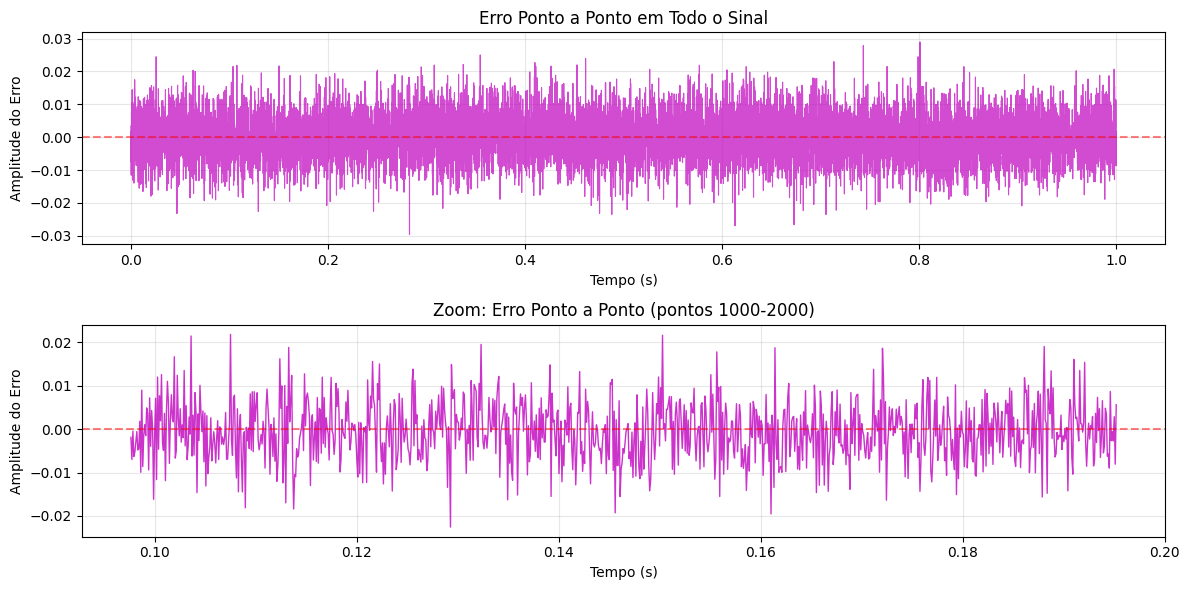

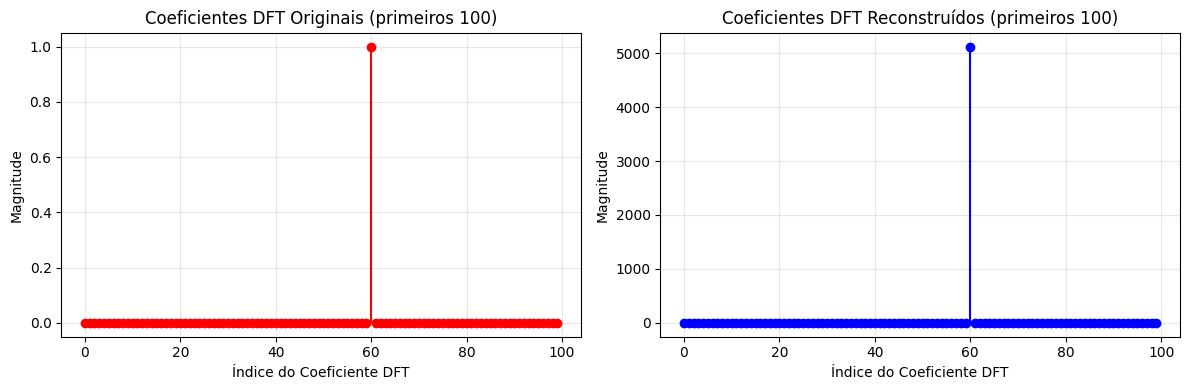

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from codecarbon import OfflineEmissionsTracker

# --- Funções de métrica ---
def calculate_prd(original, reconstructed):
    return np.sqrt(np.sum((original - reconstructed) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calculate_rmse(original, reconstructed):
    return np.sqrt(np.mean((original - reconstructed) ** 2))

# --- SL0 otimizado com máscara - VERSÃO CORRIGIDA ---
def sl0_masked(y_samples, indices, N, sigma_min=0.001, sigma_decrease_factor=0.5, mu_0=2, L=3):
    """
    SL0 corrigido para trabalhar com amostras dispersas.
    """
    # Inicialização usando mínimos quadrados
    x_hat = np.zeros(N, dtype=complex)
    x_hat[indices] = y_samples

    # Transformada inicial
    s = np.fft.fft(x_hat) / np.sqrt(N)
    sigma = 1.0  # Valor inicial de sigma

    # Processamento SL0
    while sigma > sigma_min:
        for _ in range(L):
            # Gradiente da função de suavização
            delta = s * np.exp(-np.abs(s)**2 / (sigma**2 + 1e-10))
            s = s - mu_0 * delta

            # Projeção no espaço das observações
            x_temp = np.fft.ifft(s) * np.sqrt(N)
            x_temp[indices] = y_samples  # Força as amostras conhecidas
            s = np.fft.fft(x_temp) / np.sqrt(N)

        sigma = sigma * sigma_decrease_factor

    return s

# --- Parâmetros do sinal ---
Fs = 10240
Ts = 1 / Fs
t = np.arange(Fs) * Ts
f = 60
harm = [1, 3, 7, 15, 27, 35, 45]
amplitudes = [1, 1/3, 1/7, 1/15, 1/27, 1/35, 1/45]

# Sinal original com amplitudes corretas
y = np.sum([amplitudes[i] * np.cos(2*np.pi*h*f*t) for i, h in enumerate(harm)], axis=0)
original_dft = (2/len(y)) * np.abs(np.fft.fft(y))

# Adição de ruído
SNR_dB = 40
np.random.seed(42)  # Para reprodutibilidade do ruído
ruido = np.random.normal(0, np.sqrt(np.var(y)/(10**(SNR_dB/10))), len(y))
y_ruidoso = y + ruido

# --- Compressive Sensing ---
CR = 50  # 50% de compressão
N = len(y)
M = int(N * (100 - CR) / 100)
n_iterations = 5

prd_values = np.zeros(n_iterations)
rmse_values = np.zeros(n_iterations)
prd_noisy_values = np.zeros(n_iterations)
rmse_noisy_values = np.zeros(n_iterations)
harmonic_errors = np.zeros((n_iterations, len(harm)))

# Variáveis para armazenar o sinal reconstruído da última iteração
final_rec_clean = None
final_rec_noisy = None

# --- CodeCarbon ---
tracker = OfflineEmissionsTracker(country_iso_code="BRA", output_file='emissions_SL0_masked.csv')
tracker.start()

for i in range(n_iterations):
    print(f"Iteração {i+1}/{n_iterations}")
    np.random.seed(i)  # Para reprodutibilidade
    samples = np.random.choice(N, M, replace=False)
    samples.sort()

    # --- SEM RUÍDO ---
    y_samples_clean = y[samples]
    coeffs_clean = sl0_masked(y_samples_clean, samples, N)
    rec_clean = np.real(np.fft.ifft(coeffs_clean) * np.sqrt(N))
    prd_values[i] = calculate_prd(y, rec_clean)
    rmse_values[i] = calculate_rmse(y, rec_clean)

    # --- COM RUÍDO ---
    y_samples_noisy = y_ruidoso[samples]
    coeffs_noisy = sl0_masked(y_samples_noisy, samples, N)
    rec_noisy = np.real(np.fft.ifft(coeffs_noisy) * np.sqrt(N))
    prd_noisy_values[i] = calculate_prd(y, rec_noisy)
    rmse_noisy_values[i] = calculate_rmse(y, rec_noisy)

    # Armazena a última reconstrução
    if i == n_iterations - 1:
        final_rec_clean = rec_clean.copy()
        final_rec_noisy = rec_noisy.copy()

    # --- Erros por harmônica ---
    recon_dft = (2/N) * np.abs(np.fft.fft(rec_noisy))
    for j, h_val in enumerate(harm):
        freq_pos = h_val * f
        idx_h = int(freq_pos * N / Fs)
        if 0 <= idx_h < N//2:
            if original_dft[idx_h] > 0.001:  # Evitar divisão por zero
                harmonic_errors[i,j] = 100 * np.abs(original_dft[idx_h] - recon_dft[idx_h]) / original_dft[idx_h]

# --- Resultados ---
emissions = tracker.stop()

print("\n=== Resultados ===")
print("Sinal SEM ruído:")
print(f"PRD médio: {np.mean(prd_values):.2f}% ± {np.std(prd_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_values):.4f} ± {np.std(rmse_values):.4f}")

print("\nSinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(prd_noisy_values):.2f}% ± {np.std(prd_noisy_values):.2f}%")
print(f"RMSE médio: {np.mean(rmse_noisy_values):.4f} ± {np.std(rmse_noisy_values):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, h_val in enumerate(harm):
    print(f"Harmônica {h_val}: {np.mean(harmonic_errors[:,j]):.2f}% ± {np.std(harmonic_errors[:,j]):.2f}%")

print(f"\nEmissões de CO₂: {emissions} kg")

# --- Cálculo do erro ponto a ponto ---
error_point_by_point_clean = y - final_rec_clean
error_point_by_point_noisy = y - final_rec_noisy

# --- Plots ---
plt.figure(figsize=(15, 12))

# Sinal original
plt.subplot(4, 2, 1)
plt.plot(t[:1000], y[:1000], 'r-', label='Original', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Ruído
plt.subplot(4, 2, 2)
plt.plot(t[:1000], ruido[:1000], 'gray', label='Ruído', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido')
plt.grid(True)
plt.legend()

# Sinal reconstruído
plt.subplot(4, 2, 3)
plt.plot(t[:1000], final_rec_noisy[:1000], 'b--', label='Reconstruído', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Reconstruído (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Erro de reconstrução (diferença)
plt.subplot(4, 2, 4)
plt.plot(t[:1000], error_point_by_point_noisy[:1000], 'g-', label='Erro', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Erro de Reconstrução (Original - Reconstruído)')
plt.grid(True)
plt.legend()

# Espectro de frequência
freq = np.fft.fftfreq(N, Ts)[:N//2]
fft_y = 2/N * np.abs(np.fft.fft(y)[0:N//2])
fft_rec = 2/N * np.abs(np.fft.fft(final_rec_noisy)[0:N//2])

plt.subplot(4, 2, 5)
plt.plot(freq, fft_y, 'r-', label='Original', linewidth=2)
plt.plot(freq, fft_rec, 'b--', label='Reconstruído', alpha=0.8)
for h_val in harm:
    plt.axvline(h_val*f, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.grid(True)
plt.legend()

# Erros por harmônica
plt.subplot(4, 2, 6)
harmonic_numbers = range(1, len(harm) + 1)
mean_errors = np.mean(harmonic_errors, axis=0)
std_errors = np.std(harmonic_errors, axis=0)

plt.bar(harmonic_numbers, mean_errors, yerr=std_errors,
        capsize=5, alpha=0.7, color='orange')
plt.xlabel('Número da Harmônica')
plt.ylabel('Erro Relativo (%)')
plt.title('Erros Médios por Harmônica')
plt.xticks(harmonic_numbers, [f'H{h}' for h in harm])
plt.grid(True, alpha=0.3)

# NOVO PLOT: Erro ponto a ponto detalhado
plt.subplot(4, 2, 7)
plt.plot(t[500:800], error_point_by_point_noisy[500:800], 'm-', linewidth=1.5, alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto (pontos 500-800)')
plt.grid(True, alpha=0.3)

# NOVO PLOT: Distribuição do erro
plt.subplot(4, 2, 8)
plt.hist(error_point_by_point_noisy, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Valor do Erro')
plt.ylabel('Frequência')
plt.title('Distribuição do Erro Ponto a Ponto')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot adicional: Comparação detalhada
plt.figure(figsize=(12, 4))
plt.plot(t[500:800], y[500:800], 'r-', label='Original', linewidth=2)
plt.plot(t[500:800], final_rec_noisy[500:800], 'b--', label='Reconstruído', alpha=0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação Detalhada (pontos 500-800)')
plt.grid(True)
plt.legend()
plt.show()

# NOVO PLOT: Erro ponto a ponto completo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, error_point_by_point_noisy, 'm-', alpha=0.7, linewidth=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto em Todo o Sinal')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(t[1000:2000], error_point_by_point_noisy[1000:2000], 'm-', alpha=0.8, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Zoom: Erro Ponto a Ponto (pontos 1000-2000)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot dos coeficientes DFT
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.stem(np.arange(100), original_dft[:100], 'r-', markerfmt='ro', basefmt=' ')
plt.xlabel('Índice do Coeficiente DFT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DFT Originais (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
recon_coeffs = np.fft.fft(final_rec_noisy)
plt.stem(np.arange(100), np.abs(recon_coeffs[:100]), 'b-', markerfmt='bo', basefmt=' ')
plt.xlabel('Índice do Coeficiente DFT')
plt.ylabel('Magnitude')
plt.title('Coeficientes DFT Reconstruídos (primeiros 100)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

[codecarbon INFO @ 18:01:09] offline tracker init
[codecarbon WARNING @ 18:01:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:01:09] [setup] RAM Tracking...
[codecarbon INFO @ 18:01:09] [setup] CPU Tracking...
[codecarbon WARNING @ 18:01:10] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:01:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:01:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 18:01:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:01:10] [setup] GPU Tracking...
[codecarbon INFO @ 18:01:10] No GPU found.
[codecarbon INFO @ 18:01:10] The below tracking methods have been set up:
                RAM Tracking 

Iteração 1/5
Iteração 2/5
Iteração 3/5


[codecarbon INFO @ 18:01:11] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 18:01:11] Delta energy consumed for CPU with constant : 0.000005 kWh, power : 42.5 W
[codecarbon INFO @ 18:01:11] Energy consumed for All CPU : 0.000005 kWh
[codecarbon INFO @ 18:01:11] 0.000006 kWh of electricity used since the beginning.


Iteração 4/5
Iteração 5/5

=== Resultados ===
Sinal SEM ruído:
PRD médio: 0.05% ± 0.00%
RMSE médio: 0.0004 ± 0.0000

Sinal COM ruído (SNR = 40dB):
PRD médio: 0.94% ± 0.01%
RMSE médio: 0.0071 ± 0.0000

Erros médios nas harmônicas (com ruído):
Harmônica 1: 0.01% ± 0.01%
Harmônica 3: 0.06% ± 0.04%
Harmônica 7: 0.17% ± 0.10%
Harmônica 15: 0.31% ± 0.13%
Harmônica 27: 0.20% ± 0.22%
Harmônica 35: 0.27% ± 0.13%
Harmônica 45: 0.48% ± 0.45%

Emissões de CO₂: 6.359481114144893e-07 kg


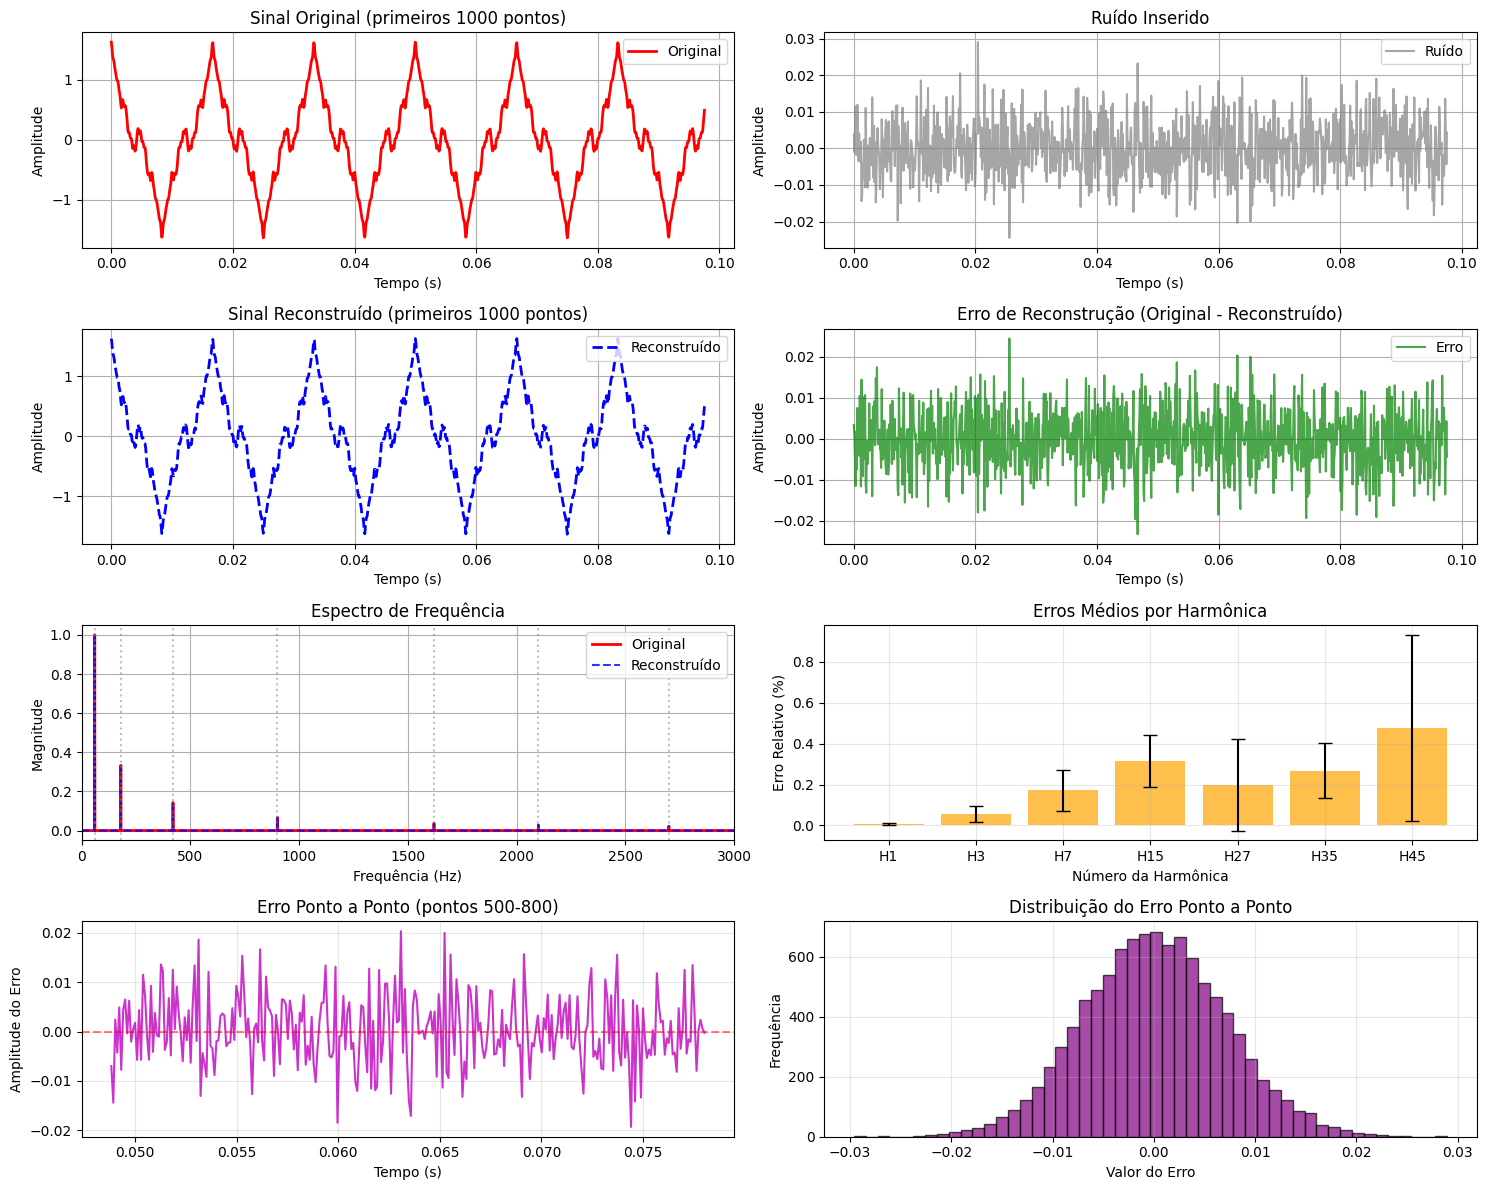

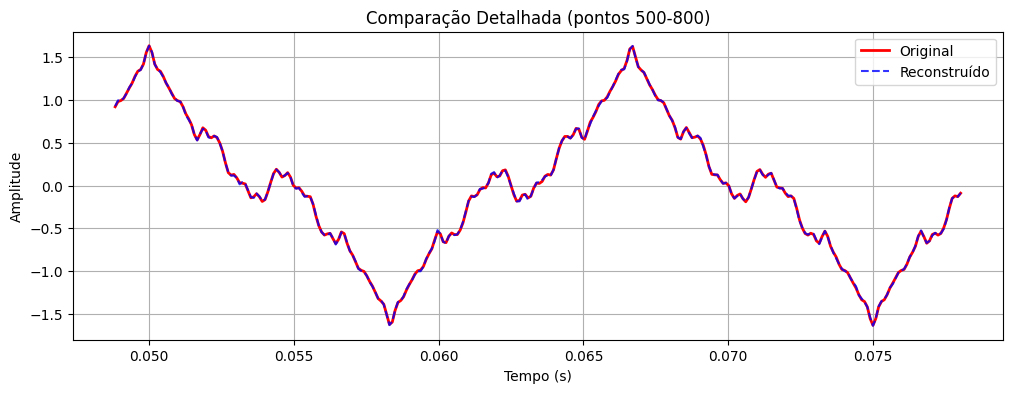

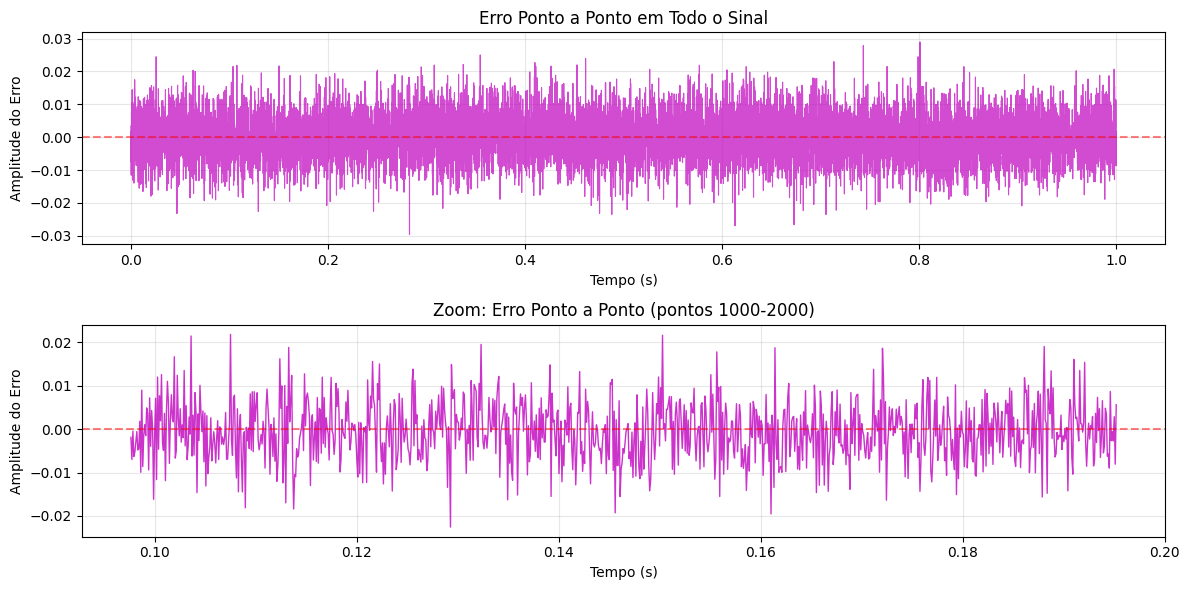


=== DEBUG: Primeiros 10 coeficientes DFT ===
Originais: [8.11175260e-17 1.70439044e-16 8.19582282e-17 2.05889349e-16
 1.16034159e-16 9.92567920e-17 6.26217966e-17 2.12591607e-16
 3.01764785e-16 4.99036254e-16]
Reconstruídos: [1.42237734e-04 5.33954379e-04 1.97747009e-05 5.28055959e-04
 7.49682638e-06 9.42546064e-06 1.21959892e-04 1.83440247e-06
 2.39085876e-04 2.10715032e-04]


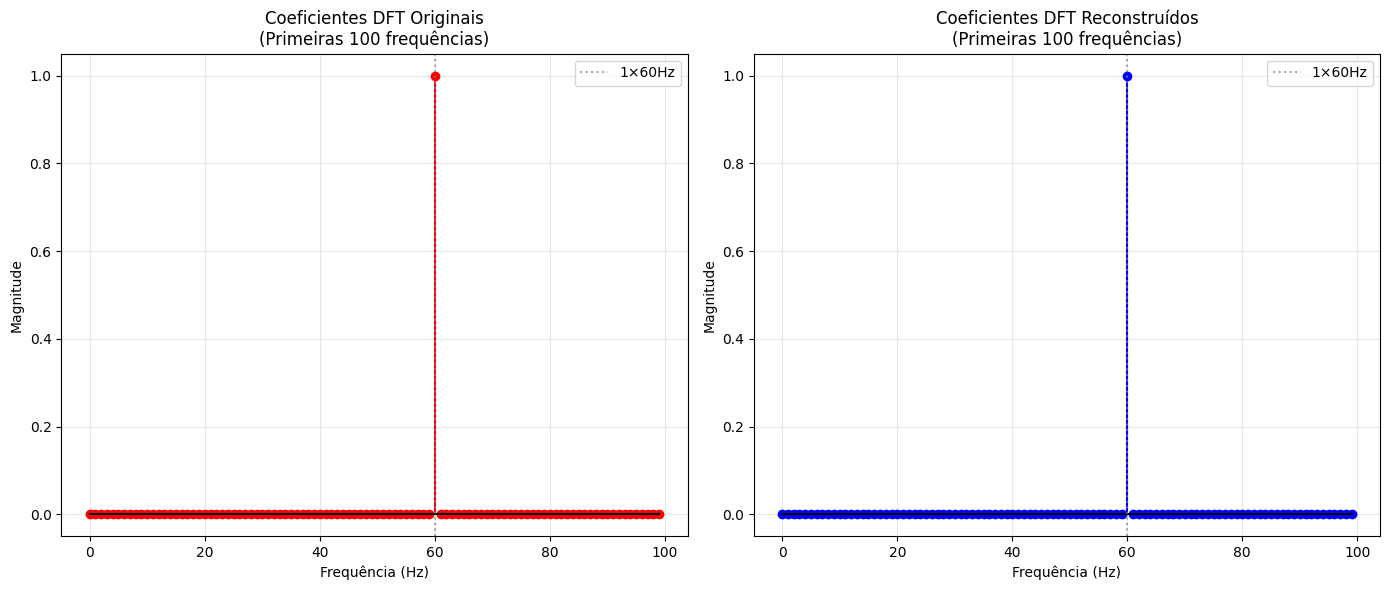

TypeError: stem() got an unexpected keyword argument 'alpha'

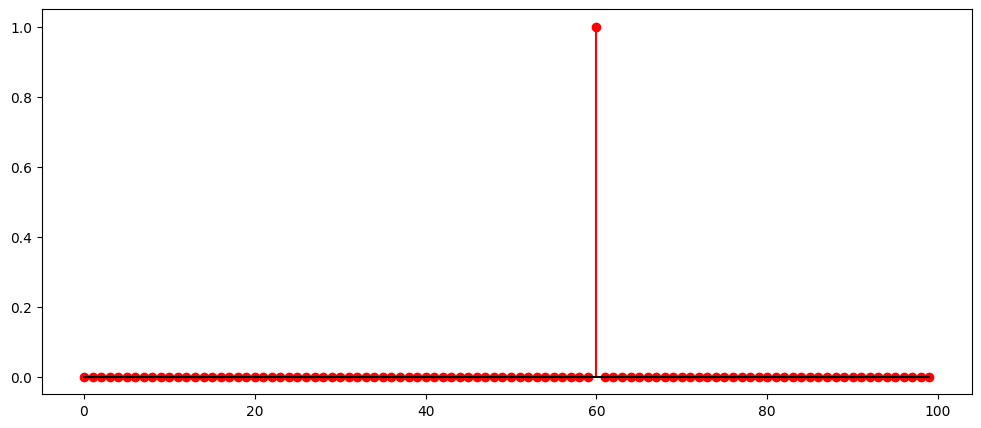

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from codecarbon import OfflineEmissionsTracker

# --- Funções de métrica ---
def calcular_prd(original, reconstruido):
    return np.sqrt(np.sum((original - reconstruido) ** 2)) / np.sqrt(np.sum(original ** 2)) * 100

def calcular_rmse(original, reconstruido):
    return np.sqrt(np.mean((original - reconstruido) ** 2))

# --- SL0 otimizado com máscara - VERSÃO CORRIGIDA ---
def sl0_com_mascara(amostras_y, indices, N, sigma_min=0.001, fator_reducao_sigma=0.5, mu_0=2, L=3):
    """
    SL0 corrigido para trabalhar com amostras dispersas.
    """
    # Inicialização usando mínimos quadrados
    x_chapeu = np.zeros(N, dtype=complex)
    x_chapeu[indices] = amostras_y

    # Transformada inicial
    s = np.fft.fft(x_chapeu) / np.sqrt(N)
    sigma = 1.0  # Valor inicial de sigma

    # Processamento SL0
    while sigma > sigma_min:
        for _ in range(L):
            # Gradiente da função de suavização
            delta = s * np.exp(-np.abs(s)**2 / (sigma**2 + 1e-10))
            s = s - mu_0 * delta

            # Projeção no espaço das observações
            x_temp = np.fft.ifft(s) * np.sqrt(N)
            x_temp[indices] = amostras_y  # Força as amostras conhecidas
            s = np.fft.fft(x_temp) / np.sqrt(N)

        sigma = sigma * fator_reducao_sigma

    return s

# --- Parâmetros do sinal ---
frequencia_amostragem = 10240
periodo_amostragem = 1 / frequencia_amostragem
tempo = np.arange(frequencia_amostragem) * periodo_amostragem
frequencia_fundamental = 60
harmonicas = [1, 3, 7, 15, 27, 35, 45]
amplitudes = [1, 1/3, 1/7, 1/15, 1/27, 1/35, 1/45]

# Sinal original com amplitudes corretas
sinal_original = np.sum([amplitudes[i] * np.cos(2*np.pi*h*frequencia_fundamental*tempo)
                        for i, h in enumerate(harmonicas)], axis=0)
dft_original = (2/len(sinal_original)) * np.abs(np.fft.fft(sinal_original))

# Adição de ruído
SNR_dB = 40
np.random.seed(42)  # Para reprodutibilidade do ruído
ruido = np.random.normal(0, np.sqrt(np.var(sinal_original)/(10**(SNR_dB/10))), len(sinal_original))
sinal_ruidoso = sinal_original + ruido

# --- Compressive Sensing ---
taxa_compressao = 50  # 50% de compressão
N = len(sinal_original)
M = int(N * (100 - taxa_compressao) / 100)
numero_iteracoes = 5

valores_prd = np.zeros(numero_iteracoes)
valores_rmse = np.zeros(numero_iteracoes)
valores_prd_ruidoso = np.zeros(numero_iteracoes)
valores_rmse_ruidoso = np.zeros(numero_iteracoes)
erros_harmonicas = np.zeros((numero_iteracoes, len(harmonicas)))

# Variáveis para armazenar o sinal reconstruído da última iteração
sinal_reconstruido_limpo = None
sinal_reconstruido_ruidoso = None

# --- CodeCarbon ---
rastreador = OfflineEmissionsTracker(country_iso_code="BRA", output_file='emissões_SL0_mascarado.csv')
rastreador.start()

for iteracao in range(numero_iteracoes):
    print(f"Iteração {iteracao+1}/{numero_iteracoes}")
    np.random.seed(iteracao)  # Para reprodutibilidade
    amostras = np.random.choice(N, M, replace=False)
    amostras.sort()

    # --- SEM RUÍDO ---
    amostras_limpas = sinal_original[amostras]
    coeficientes_limpos = sl0_com_mascara(amostras_limpas, amostras, N)
    reconstruido_limpo = np.real(np.fft.ifft(coeficientes_limpos) * np.sqrt(N))
    valores_prd[iteracao] = calcular_prd(sinal_original, reconstruido_limpo)
    valores_rmse[iteracao] = calcular_rmse(sinal_original, reconstruido_limpo)

    # --- COM RUÍDO ---
    amostras_ruidosas = sinal_ruidoso[amostras]
    coeficientes_ruidosos = sl0_com_mascara(amostras_ruidosas, amostras, N)
    reconstruido_ruidoso = np.real(np.fft.ifft(coeficientes_ruidosos) * np.sqrt(N))
    valores_prd_ruidoso[iteracao] = calcular_prd(sinal_original, reconstruido_ruidoso)
    valores_rmse_ruidoso[iteracao] = calcular_rmse(sinal_original, reconstruido_ruidoso)

    # Armazena a última reconstrução
    if iteracao == numero_iteracoes - 1:
        sinal_reconstruido_limpo = reconstruido_limpo.copy()
        sinal_reconstruido_ruidoso = reconstruido_ruidoso.copy()

    # --- Erros por harmônica ---
    dft_reconstruido = (2/N) * np.abs(np.fft.fft(reconstruido_ruidoso))
    for j, valor_h in enumerate(harmonicas):
        posicao_freq = valor_h * frequencia_fundamental
        indice_h = int(posicao_freq * N / frequencia_amostragem)
        if 0 <= indice_h < N//2:
            if dft_original[indice_h] > 0.001:  # Evitar divisão por zero
                erros_harmonicas[iteracao,j] = 100 * np.abs(dft_original[indice_h] - dft_reconstruido[indice_h]) / dft_original[indice_h]

# --- Resultados ---
emissões = rastreador.stop()

print("\n=== Resultados ===")
print("Sinal SEM ruído:")
print(f"PRD médio: {np.mean(valores_prd):.2f}% ± {np.std(valores_prd):.2f}%")
print(f"RMSE médio: {np.mean(valores_rmse):.4f} ± {np.std(valores_rmse):.4f}")

print("\nSinal COM ruído (SNR = 40dB):")
print(f"PRD médio: {np.mean(valores_prd_ruidoso):.2f}% ± {np.std(valores_prd_ruidoso):.2f}%")
print(f"RMSE médio: {np.mean(valores_rmse_ruidoso):.4f} ± {np.std(valores_rmse_ruidoso):.4f}")

print("\nErros médios nas harmônicas (com ruído):")
for j, valor_h in enumerate(harmonicas):
    print(f"Harmônica {valor_h}: {np.mean(erros_harmonicas[:,j]):.2f}% ± {np.std(erros_harmonicas[:,j]):.2f}%")

print(f"\nEmissões de CO₂: {emissões} kg")

# --- Cálculo do erro ponto a ponto ---
erro_ponto_a_ponto_limpo = sinal_original - sinal_reconstruido_limpo
erro_ponto_a_ponto_ruidoso = sinal_original - sinal_reconstruido_ruidoso

# --- Gráficos ---
figura = plt.figure(figsize=(15, 12))

# Sinal original
plt.subplot(4, 2, 1)
plt.plot(tempo[:1000], sinal_original[:1000], 'r-', label='Original', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Original (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Ruído
plt.subplot(4, 2, 2)
plt.plot(tempo[:1000], ruido[:1000], 'gray', label='Ruído', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Ruído Inserido')
plt.grid(True)
plt.legend()

# Sinal reconstruído
plt.subplot(4, 2, 3)
plt.plot(tempo[:1000], sinal_reconstruido_ruidoso[:1000], 'b--', label='Reconstruído', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Sinal Reconstruído (primeiros 1000 pontos)')
plt.grid(True)
plt.legend()

# Erro de reconstrução (diferença)
plt.subplot(4, 2, 4)
plt.plot(tempo[:1000], erro_ponto_a_ponto_ruidoso[:1000], 'g-', label='Erro', alpha=0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Erro de Reconstrução (Original - Reconstruído)')
plt.grid(True)
plt.legend()

# Espectro de frequência
frequencias = np.fft.fftfreq(N, periodo_amostragem)[:N//2]
fft_original = 2/N * np.abs(np.fft.fft(sinal_original)[0:N//2])
fft_reconstruido = 2/N * np.abs(np.fft.fft(sinal_reconstruido_ruidoso)[0:N//2])

plt.subplot(4, 2, 5)
plt.plot(frequencias, fft_original, 'r-', label='Original', linewidth=2)
plt.plot(frequencias, fft_reconstruido, 'b--', label='Reconstruído', alpha=0.8)
for valor_h in harmonicas:
    plt.axvline(valor_h*frequencia_fundamental, color='gray', linestyle=':', alpha=0.5)
plt.xlim(0, 3000)
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Espectro de Frequência')
plt.grid(True)
plt.legend()

# Erros por harmônica
plt.subplot(4, 2, 6)
numeros_harmonicas = range(1, len(harmonicas) + 1)
erros_medios = np.mean(erros_harmonicas, axis=0)
desvios_erros = np.std(erros_harmonicas, axis=0)

plt.bar(numeros_harmonicas, erros_medios, yerr=desvios_erros,
        capsize=5, alpha=0.7, color='orange')
plt.xlabel('Número da Harmônica')
plt.ylabel('Erro Relativo (%)')
plt.title('Erros Médios por Harmônica')
plt.xticks(numeros_harmonicas, [f'H{h}' for h in harmonicas])
plt.grid(True, alpha=0.3)

# NOVO GRÁFICO: Erro ponto a ponto detalhado
plt.subplot(4, 2, 7)
plt.plot(tempo[500:800], erro_ponto_a_ponto_ruidoso[500:800], 'm-', linewidth=1.5, alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto (pontos 500-800)')
plt.grid(True, alpha=0.3)

# NOVO GRÁFICO: Distribuição do erro
plt.subplot(4, 2, 8)
plt.hist(erro_ponto_a_ponto_ruidoso, bins=50, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Valor do Erro')
plt.ylabel('Frequência')
plt.title('Distribuição do Erro Ponto a Ponto')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico adicional: Comparação detalhada
plt.figure(figsize=(12, 4))
plt.plot(tempo[500:800], sinal_original[500:800], 'r-', label='Original', linewidth=2)
plt.plot(tempo[500:800], sinal_reconstruido_ruidoso[500:800], 'b--', label='Reconstruído', alpha=0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.title('Comparação Detalhada (pontos 500-800)')
plt.grid(True)
plt.legend()
plt.show()

# NOVO GRÁFICO: Erro ponto a ponto completo
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tempo, erro_ponto_a_ponto_ruidoso, 'm-', alpha=0.7, linewidth=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Erro Ponto a Ponto em Todo o Sinal')
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(tempo[1000:2000], erro_ponto_a_ponto_ruidoso[1000:2000], 'm-', alpha=0.8, linewidth=1)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude do Erro')
plt.title('Zoom: Erro Ponto a Ponto (pontos 1000-2000)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- GRÁFICO CORRIGIDO: Coeficientes DFT ---
# Primeiro, vamos ver os valores para debug
print("\n=== DEBUG: Primeiros 10 coeficientes DFT ===")
print("Originais:", dft_original[:10])
coeficientes_reconstruidos = np.fft.fft(sinal_reconstruido_ruidoso)
dft_reconstruido = (2/N) * np.abs(coeficientes_reconstruidos)
print("Reconstruídos:", dft_reconstruido[:10])

# Gráfico corrigido - usando apenas a primeira metade (até Nyquist)
numero_coeficientes_plotar = min(100, N//2)  # No máximo até a frequência de Nyquist
frequencias_plot = np.fft.fftfreq(N, periodo_amostragem)[:numero_coeficientes_plotar]  # Frequências correspondentes

plt.figure(figsize=(14, 6))

# Subplot 1: Coeficientes DFT Originais
plt.subplot(1, 2, 1)
plt.stem(frequencias_plot, dft_original[:numero_coeficientes_plotar], 'r-', markerfmt='ro', basefmt='k-', linefmt='r-')
# Destacar as harmônicas esperadas
for valor_h in harmonicas:
    freq_h = valor_h * frequencia_fundamental
    if freq_h <= frequencias_plot[-1]:  # Só destacar se estiver no range plotado
        plt.axvline(freq_h, color='gray', linestyle=':', alpha=0.7, label=f'{valor_h}×60Hz' if valor_h == harmonicas[0] else "")
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Coeficientes DFT Originais\n(Primeiras {} frequências)'.format(numero_coeficientes_plotar))
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot 2: Coeficientes DFT Reconstruídos
plt.subplot(1, 2, 2)
plt.stem(frequencias_plot, dft_reconstruido[:numero_coeficientes_plotar], 'b-', markerfmt='bo', basefmt='k-', linefmt='b-')
# Destacar as harmônicas esperadas
for valor_h in harmonicas:
    freq_h = valor_h * frequencia_fundamental
    if freq_h <= frequencias_plot[-1]:
        plt.axvline(freq_h, color='gray', linestyle=':', alpha=0.7, label=f'{valor_h}×60Hz' if valor_h == harmonicas[0] else "")
plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Coeficientes DFT Reconstruídos\n(Primeiras {} frequências)'.format(numero_coeficientes_plotar))
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# --- Gráfico adicional: Zoom nas harmônicas específicas ---
# Encontrar os índices das harmônicas
indices_harmonicas = []
frequencias_harmonicas = []
for valor_h in harmonicas:
    freq_h = valor_h * frequencia_fundamental
    indice = int(freq_h * N / frequencia_amostragem)
    if indice < N//2:
        indices_harmonicas.append(indice)
        frequencias_harmonicas.append(freq_h)

plt.figure(figsize=(12, 5))
plt.stem(frequencias_plot, dft_original[:numero_coeficientes_plotar], 'r-', markerfmt='ro', basefmt='k-', linefmt='r-', label='Original')
plt.stem(frequencias_plot, dft_reconstruido[:numero_coeficientes_plotar], 'b-', markerfmt='bo', basefmt='k-', linefmt='b-', label='Reconstruído', alpha=0.7)

# Destacar as harmônicas
for i, (indice, freq_h) in enumerate(zip(indices_harmonicas, frequencias_harmonicas)):
    if indice < numero_coeficientes_plotar:
        plt.axvline(freq_h, color='green', linestyle='--', alpha=0.5, label=f'Harmônica {harmonicas[i]}' if i == 0 else "")

plt.xlabel('Frequência (Hz)')
plt.ylabel('Magnitude')
plt.title('Comparação Detalhada: Coeficientes DFT Originais vs Reconstruídos')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, max(frequencias_harmonicas) + 100)  # Zoom até a última harmônica + margem
plt.tight_layout()
plt.show()